In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


## **Version use to update/test thresholds post NULL logic update/double intercept IT correction**

### Must run associated queries for updated Income Data and AD Data to ensure payload matching

### Dataset Import

In [2]:
# Payload File Path & Import
base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
subfile_dir = 'Prod Testing/Double_Intercept_Correction/'
filename = 'TUX_Payloads_PostDoubleInterceptCorrection.20250814.csv'

In [3]:
file_path = os.path.join(base_dir, subfile_dir, filename)

In [4]:
df = pd.read_csv(file_path, dtype={'id': str})

In [ ]:
# df = pd.read_csv(r'M:/Risk Management/DW/TUX Scorecard/Prod Testing/NullReplacementLogicTesting/AfterNullReplacementLogicUpdated_11012024-07292025-scoring.csv', dtype={'id': str})


In [5]:
# Autodecision File Path & Import
ad_base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
ad_subfile_dir = 'Prod Testing/Double_Intercept_Correction/'
ad_filename = 'Auto_Decline_Data_081425.csv'

In [6]:
# Auto Decline Data

ad_file_path = os.path.join(ad_base_dir, ad_subfile_dir, ad_filename)

df2 = pd.read_csv(ad_file_path)

# df2 = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Auto_Decline_Data_w20.xlsx')

In [ ]:
# # Autodecision File Path & Import
# ad_mininc_base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
# ad_mininc_subfile_dir = 'Prod Testing/Double_Intercept_Correction/'
# ad_mininc_filename = 'Auto_Decline_Data_MinIncome_081425.csv'

In [ ]:
# ad_mininc_file_path = os.path.join(ad_mininc_base_dir, ad_mininc_subfile_dir, ad_mininc_filename)

# df2_mininc = pd.read_csv(ad_mininc_file_path)

In [ ]:
# df3 = pd.read_excel(r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Debtor_Data.xlsx')


In [7]:
# Income File Path & Import
inc_base_dir = r'M:/Risk Management/DW/TUX Scorecard/'
inc_subfile_dir = 'Prod Testing/Double_Intercept_Correction/'
inc_filename = 'AppLevelIncomeTUXPayloadTestingData_081425.csv'

In [8]:
# Income Data

inc_file_path = os.path.join(inc_base_dir, inc_subfile_dir, inc_filename)

df4 = pd.read_csv(inc_file_path)

In [9]:
print(f"Rows in Payload Data {len(df)}")

print(f"Rows in AD Data {len(df2)}")

# print(f"Rows in AD Min Income Data {len(df2_mininc)}")

print(f"Rows in Income Data {len(df4)}")

Rows in Payload Data 346328
Rows in AD Data 866396
Rows in Income Data 866396


### Data Cleaning

In [10]:
df2.rename(columns={'bigAccountId': 'AccountId'}, inplace=True)

In [11]:
# df2_mininc.rename(columns={'bigAccountId': 'AccountId', 'MinIncome': 'MinIncome_Declines'}, inplace=True)

In [12]:
# Only update ApplicationScore when it's 0 or NaN AND ApplicantScore is non-zero/non-NaN
df.loc[
    ((df['ApplicationScore'].isna()) | (df['ApplicationScore'] == 0)) &
    (df['ApplicantScore'].notna()) & (df['ApplicantScore'] != 0),
    'ApplicationScore'
] = df['ApplicantScore']

## Mininum Income Subset

In [13]:
df4['comb_grossmonthly'] = df4['DBTREMP1_GROSSMONTHLY'].fillna(0) + df4['CODBTREMP1_GROSSMONTHLY'].fillna(0)

In [14]:
subset_cols = ['ACCOUNTID', 'APPDATE', 'DBTREMP1_GROSSMONTHLY', 'CODBTREMP1_GROSSMONTHLY', 'comb_grossmonthly']
df4_sub = df4[subset_cols]

### Impact of removing < min income apps

In [15]:
rows_before = df4_sub.shape[0]
print(f"Rows before filtering: {rows_before}")

Rows before filtering: 866396


In [16]:
count_below_3000 = (df4_sub['comb_grossmonthly'] < 3000).sum()
print(f"Number of rows with grossmonthlyincome < 3000: {count_below_3000}")

Number of rows with grossmonthlyincome < 3000: 113276


In [17]:
percent_below_3000 = count_below_3000 / len(df4_sub) * 100
print(f"Percentage of rows with grossmonthlyincome < 3000: {percent_below_3000:.2f}%")

Percentage of rows with grossmonthlyincome < 3000: 13.07%


In [18]:
df4_sub = df4_sub[df4_sub['comb_grossmonthly'] >= 3000]

In [19]:
rows_after = df4_sub.shape[0]
print(f"Rows after filtering: {rows_after}")

Rows after filtering: 753120


### Dataset Separation - Begin Joining Min. Income Subset On Main

#### only use if running with ad20 subset data

In [ ]:
# Merge df4_sub onto df_sub using Accountid
df_sub = df.merge(df4_sub, how='left', left_on='AccountId', right_on='ACCOUNTID')

# Drop AccountID column from df4_sub
df_sub.drop(columns=['ACCOUNTID'], inplace=True)

In [ ]:
print(f"Rows in Joined Data After First Merge {len(df_sub)}")

In [ ]:
df_sub = df_sub.merge(df2_mininc[['AccountId', 'dtmStampCreation', 'All_Auto_Declines', 'Conf_Fraud_Declines', 'AD167_Declines', 'MultAuto_Declines', 'ThinFile_Declines', 'BK_Declines', 'MinIncome_Declines']], 
                how='left', left_on='AccountId', right_on='AccountId')

In [ ]:
# Filter merged_df to exclude rows where All_AD_rules == 1 
final_mininc_df = df_sub[
    (df_sub['All_Auto_Declines'] != 1) # & (merged_df['ScoreEcnlMod'] != 1)
]

# Main Dataset Joins - Full Payload -

In [20]:
# Merge df4 onto df using Accountid
df = df.merge(df4_sub, how='left', left_on='AccountId', right_on='ACCOUNTID')

# Drop AccountID column from df4 
df.drop(columns=['ACCOUNTID'], inplace=True)

In [21]:
df = df.merge(df2[['AccountId', 'dtmStampCreation', 'All_Auto_Declines', 'Conf_Fraud_Declines', 'AD167_Declines', 'MultAuto_Declines', 'ThinFile_Declines', 'BK_Declines']], 
                how='left', left_on='AccountId', right_on='AccountId')


In [22]:
print(f"Rows in Joined Data After Second Merge {len(df)}")

Rows in Joined Data After Second Merge 346328


In [23]:
rows_before = df.shape[0]
print(f"Rows before filtering: {rows_before}")

Rows before filtering: 346328


In [24]:
# Filter merged_df to exclude rows where All_AD_rules == 1
final_df = df[
    (df['All_Auto_Declines'] != 1) # & (merged_df['ScoreEcnlMod'] != 1)
]

In [25]:
rows_after = final_df.shape[0]
print(f"Rows after filtering: {rows_after}")

Rows after filtering: 183276


### Pivot mean applicant score regardless of outcome

In [27]:
# Pivot showing the avg TUX credit score for the bitPrimary pivot table
AvgCrScore_DebtorType = pd.pivot_table(final_df, 
                                    values=['ApplicationScore'],
                                    index='ApplicationCreditProfileType',
                                    # columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

,ApplicationScore
ApplicationCreditProfileType,
OpenBK,687
ThickClean,666
ThickDirty,655
Thin,630


### Pivot for running with AD20 subset data

In [ ]:
# Pivot showing the avg TUX credit score for the bitPrimary pivot table
AvgCrScore_DebtorType = pd.pivot_table(final_mininc_df, 
                                    values=['ApplicantScore'],
                                    index='ApplicationCreditProfileType',
                                    # columns='bitPrimary',
                                    aggfunc='mean',
                                    fill_value=0
                                    )
AvgCrScore_DebtorType = AvgCrScore_DebtorType.astype(int)

AvgCrScore_DebtorType

### Drop payload rows from final_df where there is no scorecard segmentation data

In [28]:
final_df['ApplicantCreditProfileType'].isna().sum()

np.int64(13)

In [29]:
rw_bef = final_df.shape[0]
print(f"Rows before dropping NA from ApplicantCreditProfileType: {rw_bef}")

Rows before dropping NA from ApplicantCreditProfileType: 183276


In [30]:
final_df = final_df.dropna(subset=['ApplicantCreditProfileType'])

In [31]:
rw_aft = final_df.shape[0]
print(f"Rows after dropping NA from ApplicantCreditProfileType: {rw_aft}")

Rows after dropping NA from ApplicantCreditProfileType: 183263


## Decile Distribution Function

In [32]:
# Decile distribution plots

def plot_segmented_distributions10(df, score_col, segment_col, output_dir):

    df = df.copy()
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # New column to store quantiles
    df['EQScore_Quantile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(
            x,
            q=10,
            labels=[
                "Q1 (0-10%)", "Q2 (10-20%)", "Q3 (20-30%)", "Q4 (30-40%)", "Q5 (40-50%)", "Q6 (50-60%)", "Q7 (60-70%)", 
                "Q8 (70-80%)", "Q9 (80-90%)", "Q10 (90-100%)"], duplicates='drop'))

    # Get all unique segment values
    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Filter data for current segment
        segment_data = df[df[segment_col] == segment]
        
        # Get quantile values
        quantile_values = quantiles[segment]
        
        # Graph plot
        plt.figure(figsize=(12, 6))
        sns.histplot(segment_data[score_col], bins=20, kde=True, color='royalblue')

        # Add vertical lines for each quantile
        colors = sns.color_palette("husl", 9)
        for idx, q in enumerate(quantile_values.index):
            value = quantile_values[q]
            if pd.notna(value):
                label = f'{int(q*100)}%: {int(value)}'
            else:
                label = f'{int(q*100)}%: n/a'
                value = segment_data[score_col].mean()  # fallback line

            plt.axvline(
                value,
                color=colors[idx % len(colors)],
                linestyle='dashed',
                linewidth=1.5,
                label=label
            )

        # Plot mean line
        mean = segment_data[score_col].mean()
        # Add a dummy invisible line just for legend
        plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')

        # Add title + axis labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Legend
        plt.legend(loc='upper right', fontsize='small')
        
        # Save to file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution10s.png')
        plt.savefig(file_path)
        plt.show()
        plt.close()

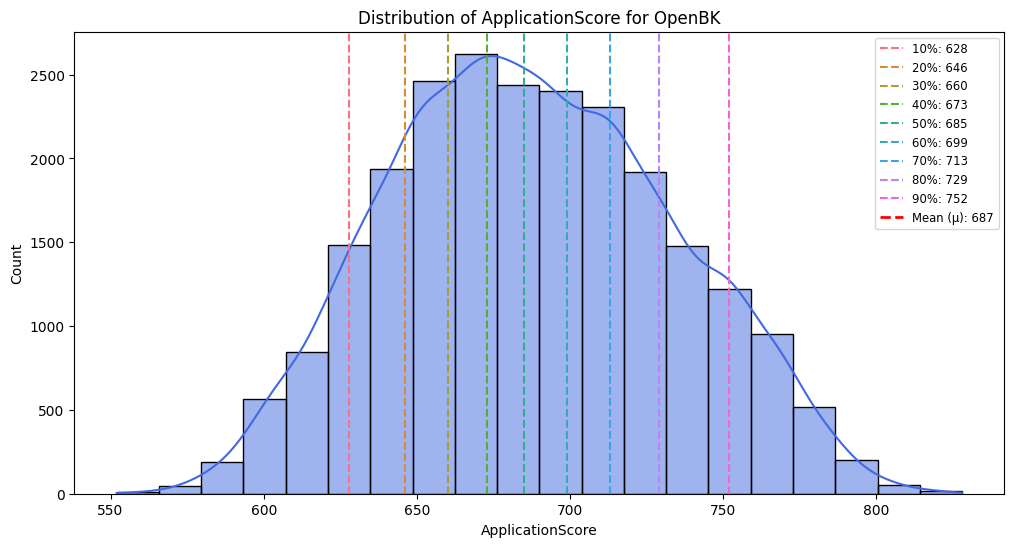

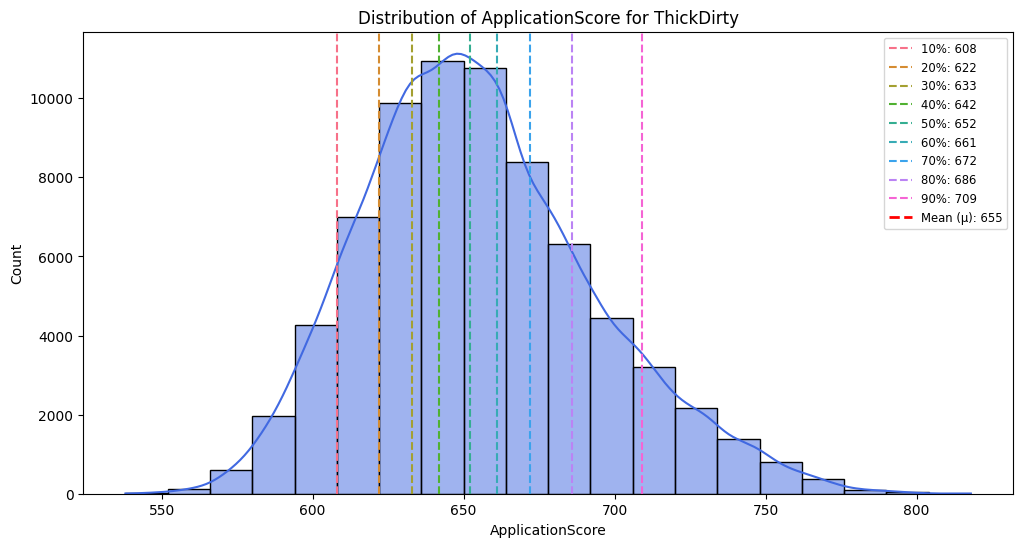

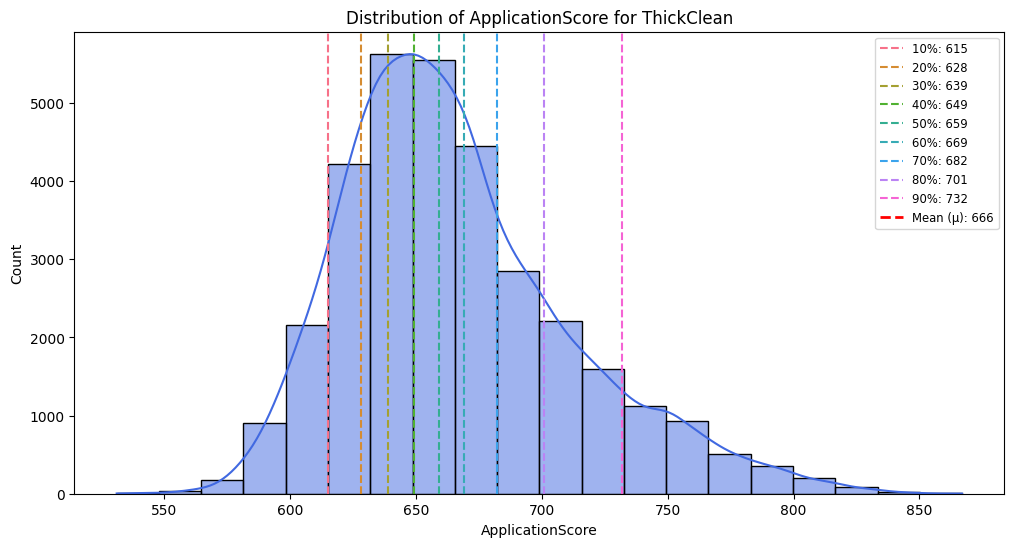

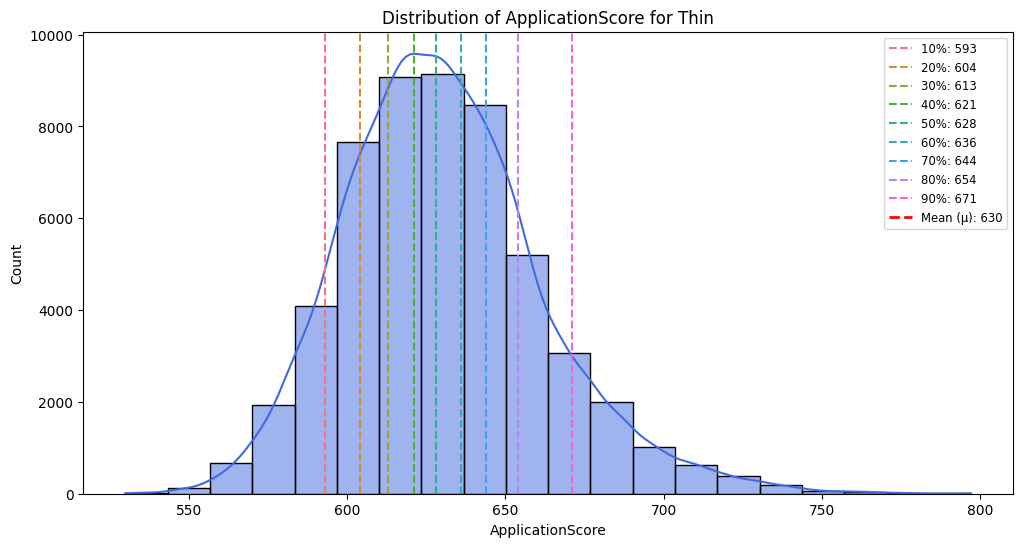

In [33]:
# Call function and export graphs

plot_segmented_distributions10(final_df, 'ApplicationScore', 'ApplicationCreditProfileType', output_dir=r'M:/Risk Management/DW/TUX Scorecard/Prod Testing/Double_Intercept_Correction/Application Score Thresholds')

In [34]:
def calculate_decile_summary(df, score_col, segment_col):
   
    # Define decile labels consistently
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]

    # Assign deciles
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=10, labels=decile_labels, duplicates='drop')
    )

    # List to store summary data
    summary_data = []
    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        for decile in decile_labels:  # Reuse same labels
            decile_data = segment_data[segment_data['EQScore_Decile10'] == decile]
            count = decile_data.shape[0]
            avg_score_mod = round(decile_data['ApplicationProb2Def'].mean(), 4) if not decile_data.empty else None
            summary_data.append([segment, decile, count, avg_score_mod])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data, columns=[segment_col, 'Decile', 'Count', 'ApplicationProb2Def'])

    # Pivot tables
    count_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='Count', aggfunc='first')
    avg_score_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='ApplicationProb2Def', aggfunc='first')

    return count_table, avg_score_table


In [35]:
# Function to display the tables with simple formatting
def display_tables(count_table, avg_score_table):
    # Print the count table and average score table
    print("Count Table (Applications per Decile):")
    print(count_table.to_string()) 
    # Print the average score table
    print("\nAverage Score Table (Avg Score per Decile):")
    print(avg_score_table.to_string())  


In [36]:
def add_decile_ranges(df, score_col, segment_col):
   
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]
    ranges = {}

    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        deciles = segment_data[score_col].quantile([i/10 for i in range(1, 10)]).values
        full_deciles = [segment_data[score_col].min()] + list(deciles) + [segment_data[score_col].max()]

        # Assign ranges
        ranges[segment] = {
            decile_labels[i]: (full_deciles[i], full_deciles[i+1]) for i in range(10)
        }

    return ranges

In [37]:
# Call the function to add ranges
ranges = add_decile_ranges(final_df, 'ApplicationScore', 'ApplicationCreditProfileType')

# Now, print the ranges for each decile
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Decile Ranges for OpenBK:
D1 (0-10%): 552 - 628
D2 (10-20%): 628 - 646
D3 (20-30%): 646 - 660
D4 (30-40%): 660 - 673
D5 (40-50%): 673 - 685
D6 (50-60%): 685 - 699
D7 (60-70%): 699 - 713
D8 (70-80%): 713 - 729
D9 (80-90%): 729 - 752
D10 (90-100%): 752 - 828

Decile Ranges for ThickDirty:
D1 (0-10%): 538 - 608
D2 (10-20%): 608 - 622
D3 (20-30%): 622 - 633
D4 (30-40%): 633 - 642
D5 (40-50%): 642 - 652
D6 (50-60%): 652 - 661
D7 (60-70%): 661 - 672
D8 (70-80%): 672 - 686
D9 (80-90%): 686 - 709
D10 (90-100%): 709 - 818

Decile Ranges for ThickClean:
D1 (0-10%): 531 - 615
D2 (10-20%): 615 - 628
D3 (20-30%): 628 - 639
D4 (30-40%): 639 - 649
D5 (40-50%): 649 - 659
D6 (50-60%): 659 - 669
D7 (60-70%): 669 - 682
D8 (70-80%): 682 - 701
D9 (80-90%): 701 - 732
D10 (90-100%): 732 - 867

Decile Ranges for Thin:
D1 (0-10%): 530 - 593
D2 (10-20%): 593 - 604
D3 (20-30%): 604 - 613
D4 (30-40%): 613 - 621
D5 (40-50%): 621 - 628
D6 (50-60%): 628 - 636
D7 (60-70%): 636 - 644
D8 (70-80%): 644 - 654
D9 (80-90%

In [38]:
# Count table

# Calculate the decile summaries
count_table, avg_score_table = calculate_decile_summary(final_df, 'ApplicationScore', 'ApplicationCreditProfileType')

# Display the tables
display_tables(count_table, avg_score_table)

# Get the decile ranges
ranges = add_decile_ranges(final_df, 'ApplicationScore', 'ApplicationCreditProfileType')

# Print the ranges
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


Count Table (Applications per Decile):
Decile                        D1 (0-10%)  D10 (90-100%)  D2 (10-20%)  D3 (20-30%)  D4 (30-40%)  D5 (40-50%)  D6 (50-60%)  D7 (60-70%)  D8 (70-80%)  D9 (80-90%)
ApplicationCreditProfileType                                                                                                                                   
OpenBK                              2438           2273         2348         2394         2413         2263         2480         2322         2312         2434
ThickClean                          3454           3221         3199         3451         3379         3283         3132         3238         3309         3345
ThickDirty                          7386           7028         7230         7671         6852         8003         6937         7115         7058         7508
Thin                                5636           5340         5307         5489         5722         4994         5579         5094         5388         5238



In [39]:
# Generate decile ranges table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)


# Output filename
output_filename = 'M:/Risk Management/DW/TUX Scorecard/Prod Testing/Double_Intercept_Correction/Application Score Thresholds/ApplicationThresholds.20250814.xlsx'


In [42]:
# Define paths
output_dir = 'M:/Risk Management/DW/TUX Scorecard/Prod Testing/Double_Intercept_Correction/Application Score Thresholds/'
output_filename = os.path.join(output_dir, 'ApplicationThresholds.20250814.xlsx')

# Recompute decile range table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)

# Write all to Excel 
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    final_df.to_excel(writer, sheet_name='df_ApplicationThresholds_Data', index=False)
    count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')
    ranges_df.to_excel(writer, sheet_name='Decile Threshold Ranges', index=False)

print(f"Workbook saved: {output_filename}")

Workbook saved: M:/Risk Management/DW/TUX Scorecard/Prod Testing/Double_Intercept_Correction/Application Score Thresholds/ApplicationThresholds.20250814.xlsx


## Below is degredated

In [ ]:
df3.rename(columns={'bigaccountid': 'AccountId'}, inplace=True)

In [ ]:
# # extract debtorid from id column in df
# df['DebtorID'] = df['id'].astype(str).str[7:15]

In [ ]:
# # df['DebtorID'] = df['DebtorID'].astype(int)
# df['DebtorID'] = pd.to_numeric(df['DebtorID'], errors='coerce').astype('Int64')

In [ ]:
# df3.rename(columns={'bigaccountid': 'AccountId', 'bigdebtorid': 'DebtorId', 'bigDebtorId2': 'DebtorId2'}, inplace=True)

In [ ]:
# df3['DebtorId'] = df3['DebtorId'].astype('Int64')
# df3['DebtorId2'] = df3['DebtorId2'].astype('Int64')

In [ ]:
# # Merge df with df3 to check for a primary match
# df = df.merge(df3[['DebtorId', 'DebtorId2']], how='left', left_on='DebtorID', right_on='DebtorId')

In [ ]:
# # Merge df again to check for a co-applicant match (ApplicantID == ApplicantId2)
# df = df.merge(df3[['DebtorId', 'DebtorId2']], how='left', left_on='DebtorID', right_on='DebtorId2', suffixes=('_primary', '_coapp'))

In [ ]:
# # Create 'bitPrimary' column
# df['bitPrimary'] = df.apply(lambda x: 
#     1 if pd.notna(x['DebtorID']) and pd.notna(x['DebtorId_primary']) and x['DebtorID'] == x['DebtorId_primary']
#     else (0 if pd.notna(x['DebtorID']) and pd.notna(x['DebtorId2_coapp']) and x['DebtorID'] == x['DebtorId2_coapp']
#           else None), axis=1)

In [ ]:
# print(df['DebtorID'].head())
# print(df3['DebtorId'].head())


In [ ]:
# drop unnecessary columns
# df = df.drop(['ErrorMessage', 'SourceFileName', 'id', 'RowId', 'RequestId'], axis=1)

In [ ]:
df2.rename(columns={'bigAccountId': 'AccountId'}, inplace=True)

In [ ]:
df4.rename(columns={'ACCOUNTID': 'ACCOUNT_ID', 'DBTREMP1_GROSSMONTHLY': 'DebtorTtlIncome', 'CODBTREMP1_GROSSMONTHLY': 'CoDebtorTtlIncome'}, inplace=True)

In [ ]:
# Merge df4 onto df using Accountid
df = df.merge(df4[['ACCOUNT_ID', 'DEBTOR_ID', 'DebtorTtlIncome', 'CODEBTOR_ID', 'CoDebtorTtlIncome']], 
                how='left', left_on='AccountId', right_on='ACCOUNT_ID')

# Drop AccountID column from df4 
df.drop(columns=['ACCOUNT_ID'], inplace=True)

In [ ]:
# df2.info()

In [ ]:
# merged_df.info()

In [ ]:
# merged_df = pd.merge(df, df2, on='AccountId', how='left')

In [ ]:
df = df.merge(df2[['AccountId', 'dtmStampCreation', 'All_Auto_Declines', 'Conf_Fraud_Declines', 'AD167_Declines', 'MultAuto_Declines', 'ThinFile_Declines', 'BK_Declines']], 
                how='left', left_on='AccountId', right_on='AccountId')


In [ ]:
merged_df = pd.merge(df, df3, on='AccountId', how='left')

In [ ]:
rows_before = merged_df.shape[0]
print(f"Rows before filtering: {rows_before}")

In [ ]:
# Filter merged_df to exclude rows where All_AD_rules == 1 and ScoreEcnlMod == 1
final_df = merged_df[
    (merged_df['All_Auto_Declines'] != 1) # & (merged_df['ScoreEcnlMod'] != 1)
]

In [ ]:
rows_after = final_df.shape[0]
print(f"Rows after filtering: {rows_after}")

In [ ]:
df_final = final_df.copy()

In [ ]:
df_zero_score = df_final[df_final['ApplicationScore_after'] == 0].copy()
df_scored = df_final[df_final['ApplicationScore_after'] > 0].copy()

In [ ]:
# standard deviation histogram function

def plot_std_histograms(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    unique_segments = df[segment_col].unique()
    
    for segment in unique_segments:
        subset = df[df[segment_col] == segment]
        mean = subset[score_col].mean()
        std = subset[score_col].std()
        
        # Calculate standard deviation boundaries and convert to integer
        if pd.notna(mean) and pd.notna(std):
            minus_1_std = int(mean - std)
            plus_1_std = int(mean + std)
            minus_2_std = int(mean - 2 * std)
            plus_2_std = int(mean + 2 * std)
            # Continue plotting
        else:
            print(f"Skipping {segment} due to NaN mean or std.")
            continue
    
        # minus_1_std = int(mean - std)
        # plus_1_std = int(mean + std)
        # minus_2_std = int(mean - 2 * std)
        # plus_2_std = int(mean + 2 * std)
        
        # Define the number of bins manually to control x-axis
        bin_width = (subset[score_col].max() - subset[score_col].min()) / 20
        bins = int((subset[score_col].max() - subset[score_col].min()) / bin_width)

        # Create a new figure
        plt.figure(figsize=(8, 5))
        
        # Plot the histogram with KDE
        sns.histplot(subset[score_col], bins=bins, kde=True, color='royalblue', alpha=0.6)
        
        # Plot mean and standard deviation lines
        line_1 = plt.axvline(mean, color='red', linestyle='dashed', linewidth=2)
        line_minus_1_std = plt.axvline(minus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_plus_1_std = plt.axvline(plus_1_std, color='orange', linestyle='dashed', linewidth=2)
        line_minus_2_std = plt.axvline(minus_2_std, color='green', linestyle='dashed', linewidth=2)
        line_plus_2_std = plt.axvline(plus_2_std, color='green', linestyle='dashed', linewidth=2)

        # Add the lines and their corresponding values in the legend
        plt.legend(
            handles=[line_1, line_plus_1_std, line_minus_1_std, line_plus_2_std, line_minus_2_std],
            labels=[f'Mean (μ): {int(mean)}', f'+1σ: {plus_1_std}', f'-1σ: {minus_1_std}', f'+2σ: {plus_2_std}', f'-2σ: {minus_2_std}'],
            loc='upper right'
        )
        
        # Title and labels
        plt.title(f'Score Distribution for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_std_distribution.png')
        plt.savefig(file_path) 

        plt.show()
        plt.close()

In [ ]:
# st. dev histograms on Applicant Score
output_dir = r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/'

plot_std_histograms(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after', output_dir)

In [ ]:
# st. dev histograms on Application Score
output_dir = r'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/'

plot_std_histograms(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after', output_dir)

In [ ]:
# Decile distribution plots

def plot_segmented_distributions10(df, score_col, segment_col, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Dictionary to store quantiles for each segment
    quantiles = {}
    for segment in df[segment_col].unique():
        quantiles[segment] = df[df[segment_col] == segment][score_col].quantile(
            [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    # Create a new column to store the quantile categories
    df['EQScore_Quantile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(
            x,
            q=10,
            labels=[
                "Q1 (0-10%)", "Q2 (10-20%)", "Q3 (20-30%)", "Q4 (30-40%)", "Q5 (40-50%)", "Q6 (50-60%)", "Q7 (60-70%)", 
                "Q8 (70-80%)", "Q9 (80-90%)", "Q10 (90-100%)"], duplicates='drop'))

    # Get all unique segment values
    unique_segments = df[segment_col].unique()

    for segment in unique_segments:
        # Filter data for the current segment
        segment_data = df[df[segment_col] == segment]
        
        # Get the quantile values
        quantile_values = quantiles[segment]
        
        # Create the plot
        plt.figure(figsize=(12, 6))
        sns.histplot(segment_data[score_col], bins=20, kde=True, color='royalblue')

        # Plot vertical dashed lines for each quantile (10% to 90%)
        colors = sns.color_palette("husl", 9)
        for idx, q in enumerate(quantile_values.index):
            value = quantile_values[q]
            if pd.notna(value):
                label = f'{int(q*100)}%: {int(value)}'
            else:
                label = f'{int(q*100)}%: n/a'
                value = segment_data[score_col].mean()  # fallback line

            plt.axvline(
                value,
                color=colors[idx % len(colors)],
                linestyle='dashed',
                linewidth=1.5,
                label=label
            )

        # Plot the mean line
        mean = segment_data[score_col].mean()
        # Add a dummy invisible line just for legend
        plt.plot([], [], color='red', linestyle='dashed', linewidth=2, label=f'Mean (μ): {int(mean)}')

        # Add title and axis labels
        plt.title(f'Distribution of {score_col} for {segment}')
        plt.xlabel(score_col)
        plt.ylabel('Count')

        # Add legend
        plt.legend(loc='upper right', fontsize='small')
        
        # Save the plot to a file
        file_path = os.path.join(output_dir, f'{segment}_{score_col}_distribution10s.png')
        plt.savefig(file_path)
        plt.show()
        plt.close()

In [ ]:
plot_segmented_distributions10(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after', output_dir='M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/')


In [ ]:
# 0-score declines per segment
zero_score_summary = df_zero_score.groupby('ApplicationCreditProfileType_after').size().reset_index(name='ZeroScoreDeclines')
print(zero_score_summary)


In [ ]:
sns.barplot(data=zero_score_summary, x='ApplicationCreditProfileType_after', y='ZeroScoreDeclines')
plt.title('0-Score Policy Declines by Scorecard Segment')
plt.ylabel('Count')
plt.xlabel('Segment')
plt.show()


In [ ]:
def calculate_decile_summary(df, score_col, segment_col):
    # Dedup records, keeping only applicant level
    # df = df[df['bitPrimary'] == 1].copy()
    
    # Define decile labels consistently
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]

    # Assign deciles
    df['EQScore_Decile10'] = df.groupby(segment_col)[score_col].transform(
        lambda x: pd.qcut(x, q=10, labels=decile_labels, duplicates='drop')
    )

    # Prepare a list to store the summary data
    summary_data = []
    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        for decile in decile_labels:  # Reuse same labels
            decile_data = segment_data[segment_data['EQScore_Decile10'] == decile]
            count = decile_data.shape[0]
            avg_score_mod = round(decile_data['ApplicationProb2Def_after'].mean(), 4) if not decile_data.empty else None
            summary_data.append([segment, decile, count, avg_score_mod])

    # Convert to DataFrame
    summary_df = pd.DataFrame(summary_data, columns=[segment_col, 'Decile', 'Count', 'ApplicationProb2Def_after'])

    # Pivot tables
    count_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='Count', aggfunc='first')
    avg_score_table = summary_df.pivot_table(index=segment_col, columns='Decile', values='ApplicationProb2Def_after', aggfunc='first')

    return count_table, avg_score_table


In [ ]:
# Function to display the tables with simple formatting
def display_tables(count_table, avg_score_table):
    # Print the count table and average score table
    print("Count Table (Applications per Decile):")
    print(count_table.to_string())  # Use .to_string() for better formatting in console
    
    print("\nAverage Score Table (Avg Score per Decile):")
    print(avg_score_table.to_string())  # Print the average score table


In [ ]:
def add_decile_ranges(df, score_col, segment_col):
    # Dedup to applicant level rows only
    # df = df[df['bitPrimary'] == 1].copy()
    
    decile_labels = [f"D{i+1} ({i*10}-{(i+1)*10}%)" for i in range(10)]
    ranges = {}

    for segment in df[segment_col].unique():
        segment_data = df[df[segment_col] == segment]
        deciles = segment_data[score_col].quantile([i/10 for i in range(1, 10)]).values
        full_deciles = [segment_data[score_col].min()] + list(deciles) + [segment_data[score_col].max()]

        # Assign ranges
        ranges[segment] = {
            decile_labels[i]: (full_deciles[i], full_deciles[i+1]) for i in range(10)
        }

    return ranges

In [ ]:
# Call the function to add ranges
ranges = add_decile_ranges(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after')

# Now, print the ranges for each decile
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")

In [ ]:
# Count table
# Filter once for application-level view
# df_scored_copy = df_scored[df_scored['bitPrimary'] == 1].copy()

# Calculate the decile summaries
count_table, avg_score_table = calculate_decile_summary(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after')

# Display the tables
display_tables(count_table, avg_score_table)

# Get the decile ranges
ranges = add_decile_ranges(df_scored, 'ApplicationScore_after', 'ApplicationCreditProfileType_after')

# Print the ranges
for segment, decile_ranges in ranges.items():
    print(f"\nDecile Ranges for {segment}:")
    for decile, (low, high) in decile_ranges.items():
        print(f"{decile}: {low:.0f} - {high:.0f}")


In [ ]:
# Generate decile ranges table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)


# Define output filename
output_filename = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/App_Level_Thresholds_8.5.25_minincome.xlsx'


In [ ]:
# Define paths
output_dir = 'M:/Risk Management/DW/TUX Scorecard/TUX_Scores/Updated Threshold Testing.Post Initial Release.7.29.25/Output Files/AfterNullReplacementUpdate/'
output_filename = os.path.join(output_dir, 'App_Level_Thresholds_8.5.25_minincome.xlsx')

# Recompute decile range table
decile_rows = []
for segment, decile_ranges in ranges.items():
    for decile, (low, high) in decile_ranges.items():
        decile_rows.append({
            'Segment': segment,
            'Decile': decile,
            'Min Score': round(low, 0),
            'Max Score': round(high, 0)
        })
ranges_df = pd.DataFrame(decile_rows)

# Bar plot: 0-score declines per segment
zero_score_summary = df_zero_score.groupby('ApplicationCreditProfileType_after').size().reset_index(name='ZeroScoreDeclines')
plot_path = os.path.join(output_dir, 'zero_score_declines.png')
plt.figure(figsize=(8, 5))
sns.barplot(data=zero_score_summary, x='ApplicationCreditProfileType_after', y='ZeroScoreDeclines')
plt.title('0-Score Policy Declines by Scorecard Segment')
plt.ylabel('Count')
plt.xlabel('Segment')
plt.tight_layout()
plt.savefig(plot_path)
plt.close()

# Write all to Excel using xlsxwriter
with pd.ExcelWriter(output_filename, engine='xlsxwriter') as writer:
    df_scored.to_excel(writer, sheet_name='df_scored_Full', index=False)
    count_table.to_excel(writer, sheet_name='Decile Threshold Counts')
    avg_score_table.to_excel(writer, sheet_name='Avg Prob2Def')
    ranges_df.to_excel(writer, sheet_name='Decile Threshold Ranges', index=False)
    zero_score_summary.to_excel(writer, sheet_name='Zero Score Declines', index=False)
    
    # If you want, you can include a link or note to the image
    workbook  = writer.book
    worksheet = workbook.add_worksheet('Plot Summary')
    worksheet.write('A1', 'Plot saved separately at:')
    worksheet.write('A2', plot_path)

print(f"Workbook saved: {output_filename}")
print(f"Plot saved: {plot_path}")
